Estimate the Posterior with Bayes and Markov Chain Monte Carlo (MCMC)
-----

<center><img src="https://www.predikkta.com/site-images/ctr-formula.png" width="500"/></center>

A company has hired you to help assess their new ad campaign.

In [1]:
reset -fs

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import factorial
from scipy.stats import beta
import seaborn as sns
%matplotlib inline

-----
Likelihood
-----

In [3]:
def likelihood(theta, n, x):
    "Likelihood function for a binomial distribution"
    return (factorial(n) / (factorial(x) * factorial(n - x))) \
            * (theta ** x) * ((1 - theta) ** (n - x))

The ad has been presented to 10 users so far, and 7 of the users have clicked on it. We would like to estimate the probability that the next user will click on the ad. 

In [75]:
# TODO: Find the MLE for Theta

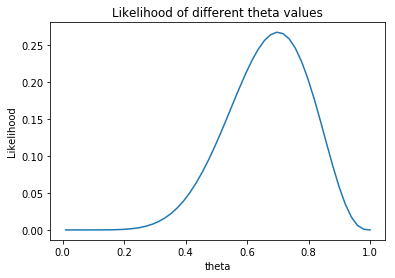

In [27]:
plt.plot(np.linspace(.01,1,50),[likelihood(i,10,7) for i in np.linspace(.01,1,50)])
plt.title('Likelihood of different theta values')
plt.xlabel('theta')
plt.ylabel('Likelihood')

In [22]:
print(f"The MLE for the binomial is {np.linspace(.01,1,50)[np.argmax(np.array([likelihood(i,10,7)\
      for i in np.linspace(.01,1,50)]))]}") 

The MLE for the binomial is 0.6969387755102041


In [35]:
mle = 0.6969387755102041
possible_theta_values = np.linspace(.01,1,50)
likelihoods = [likelihood(i,10,7) for i in np.linspace(.01,1,50)]

In [36]:
# TODO: Plot the likelihoods and the MLE for Theta

-----
The Prior
-----

However, some of the other analysts are skeptical. The performance of this campaign seems extremely high given how our other campaigns have done historically. 

Let's overlay this likelihood function with the distribution of success rates from our previous campaigns:

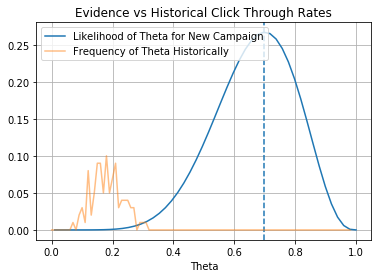

In [37]:
# Historical data:

click_through_rates = np.array([ 0.15835141,  0.24594907,  0.23203796,  0.1697417 ,  0.26456219,
        0.10688894,  0.15942029,  0.10251509,  0.21555916,  0.26701571,
        0.22357845,  0.09484649,  0.30164751,  0.25938926,  0.20065635,
        0.21978022,  0.12796353,  0.22071393,  0.16535174,  0.16429616,
        0.11485149,  0.12111554,  0.1498829 ,  0.15991211,  0.25595873,
        0.21068217,  0.15643511,  0.21726526,  0.22079879,  0.13604666,
        0.18088553,  0.13316195,  0.15502451,  0.12268956,  0.18240807,
        0.12761254,  0.20318112,  0.12689007,  0.19252008,  0.18780152,
        0.18663905,  0.29960441,  0.18061674,  0.17408124,  0.19622715,
        0.12341419,  0.27224603,  0.19687142,  0.23680456,  0.16712235,
        0.14273431,  0.17844061,  0.20477619,  0.15386883,  0.24710801,
        0.14167209,  0.21142326,  0.16989485,  0.21256039,  0.14577685,
        0.15675331,  0.1918745 ,  0.25055707,  0.24775785,  0.23608445,
        0.21158309,  0.16586965,  0.12852698,  0.18548387,  0.16216216,
        0.21016629,  0.20659004,  0.273906  ,  0.16026009,  0.17994263,
        0.0931338 ,  0.23344397,  0.15880994,  0.12904559,  0.07740692,
        0.1784027 ,  0.1030481 ,  0.2738525 ,  0.26075949,  0.25295508,
        0.18004382,  0.21100596,  0.20576132,  0.24811835,  0.1496106 ,
        0.17937585,  0.16192643,  0.18058628,  0.15143824,  0.20622568,
        0.31488673,  0.20617611,  0.19254186,  0.18061089,  0.1891835 ])

f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)

zero_to_one = [j/100. for j in range(100)]
counts, bins = np.histogram(click_through_rates
                            , bins=zero_to_one)
counts = counts / 100.
ax.plot(bins[:-1],counts, alpha = .5)
line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign'
                           , 'Frequency of Theta Historically')
                          , loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Evidence vs Historical Click Through Rates")
plt.show()

__TODO__:  Summarize how the relationship between historical data and Theta

In [38]:
# The historical data is showign a strong divergence from the new data. 

In [80]:
# TODO: Fit beta to previous CTRs using scipy.stats.beta

In [42]:
a,b,loc,scale = beta.fit(click_through_rates)
a,b,loc,scale 

(3.7754429158741911,
 5.2498113808926199,
 0.053576917176056581,
 0.32099986822245874)

In [82]:
# TODO: Plot estimated prior

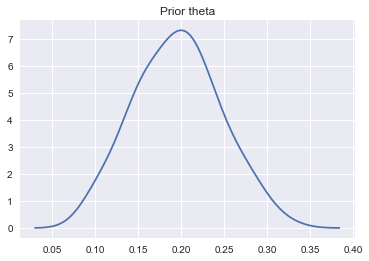

In [46]:
sns.kdeplot(beta(a,b,loc,scale ).rvs(100))
plt.title('Prior theta')

----
The Posterior
----

Let's now obtain samples from the posterior. We select our prior as a Beta(α, β) from last step

In [74]:
n_clicks = 7
n_impressions = 10

In [75]:
import pymc3 as pm

In [76]:
clicks = np.array([n_clicks])
impressions = np.array([n_impressions])

with pm.Model() as model:

    theta_prior = pm.Beta('prior', 11.5, 48.5)
    observations = pm.Binomial('obs',
                               n=impressions,
                               p=theta_prior,
                               observed = clicks)     

    start = pm.find_MAP()    # Find good starting values for the sampling algorithm

    step = pm.NUTS(state=start)     # Choose a particular MCMC algorithm     

    # Obtain samples
    trace = pm.sample(5000, 
                      step,
                      start=start, 
                      progressbar=True)              

INFO (theano.gof.compilelock): Refreshing lock /Users/jonathanhilgart/.theano/compiledir_Darwin-16.5.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 6.130835


100%|██████████| 5000/5000 [00:02<00:00, 2487.09it/s]

         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


In [91]:
prior_samples = beta(a,b,loc,scale ).rvs(300)

In [92]:
prior_samples[:10]

array([ 0.22359204,  0.18340197,  0.25634777,  0.27115965,  0.2228794 ,
        0.15604085,  0.16937665,  0.30309105,  0.14865777,  0.22187045])

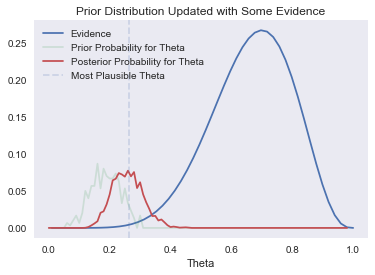

In [94]:
# Get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior'],
                                                bins=zero_to_one)

#  Normalized histogramp
posterior_counts = posterior_counts / float(posterior_counts.sum())
# Take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])
# Histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples
                                  , zero_to_one)#normalize
prior_counts = list(map(lambda x: float(x)/prior_counts.sum()
                   , prior_counts))
# Plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.plot(bins[:-1],prior_counts, alpha = .2)
ax.plot(bins[:-1],posterior_counts)
ax.axvline(most_plausible_theta, linestyle = "--", alpha = .2)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence',
                                         'Prior Probability for Theta',
                                         'Posterior Probability for Theta',
                                         'Most Plausible Theta',), loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid()
ax.set_title("Prior Distribution Updated with Some Evidence")
plt.show()

__TODO__: What does the posterior tell us about the campaign?

In [95]:
# This is evidence that the campaign is useful! 